<a href="https://colab.research.google.com/github/ChaejinE/MyPytorch/blob/main/b_DataSet_Loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
- Readability, modularity를 위해 데이터셋 코드를 모델 학습 코드로 부터 분리하는 것이 이상적이다.
- PyTorch는 torch.utils.data.DataLoader, torch.utils.data.Dataset 두 가지 데이터 기본 요소를 제공해 미리 준비해둔 데이터셋 뿐아니라 가지고 있는 데이터를 사용할 수 있다.
  - Dataset : sample, label을 저장한다.
  - DataLoader : Datset 샘플에 쉽게 접근하도록 Iterable 객체로 감싼다.
## PyTorch 도메인 특화 라이브러리
- Like the "FashionMNIST"
  - pre-loaded Dataset 제공
- torch.utils.data.Data의 하위 클래스로 개별 데이터를 특정하는 함수가 구현되어 있다.
  - [ImageDataSet](https://pytorch.org/vision/stable/datasets.html)
  - [TextDataSet](https://pytorch.org/text/stable/datasets.html)
  - [AudioDataSet](https://pytorch.org/audio/stable/datasets.html)



# DataSet Load
- TorchVsion에서 Fashion-MNIST 데이터를 불러온다.
- 60,000개의 학습 데이터, 10,000개의 테스트 데이터
- GrayScale 28x28 Image
- Class 10개

In [1]:
import torch

In [3]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# root : 학습/테스트 데이터가 저장되는 경로
# train : 학습용 또는 테스트용 데이터셋 여부 지정
# download : True인 경우 root에 데이터가 없을 때 인터네에서 다운로드
# transform, target_tranform : Feature과 label 변형을 지정한다.

train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform= ToTensor()
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform= ToTensor()
)

# Dataset 순회 및 시각화
- Dataset에 list처럼 index해서 접근할 수 있다.

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [10]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

<Figure size 576x576 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


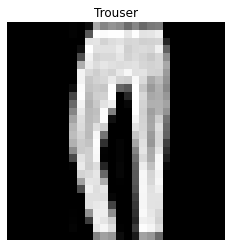

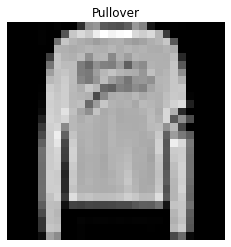

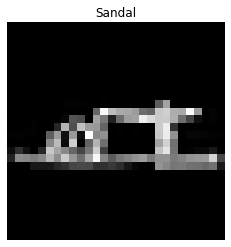

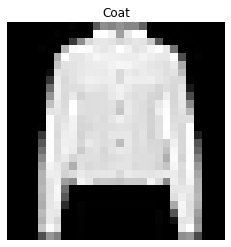

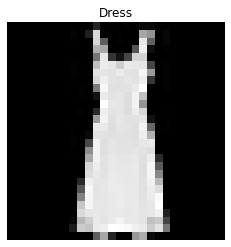

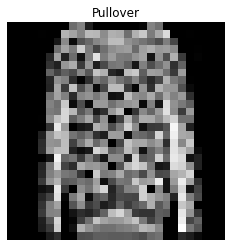

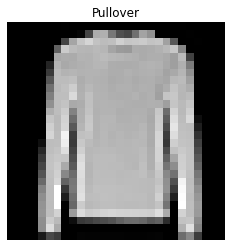

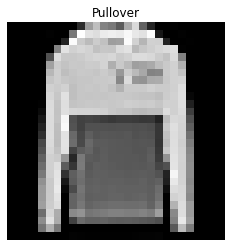

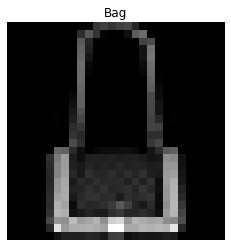

In [16]:
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")  
    plt.show()

# 사용자 정의 데이터셋 만들기
- 반드시 3개 함수를 구현해야 한다.
  - __init__()
  - __len__()
  - __getitem__()
- FashionMNIST 이미지들 기준으로 이미지는 img_dir에, 정답은 annotations_file (csv file)에 별도로 저장된다.
## Detail
- labels.csv 파일은 아래와 같다.
  - tshirt1.jpg, 0
  - tshirt2.jpg, 0
  - ...
  - ankleboot999.jpg, 9
- __init__에서 이미지와 레이블 파일이 포함된 디렉토리 및 변형을 초기화한다.
- __len__ 에서는 샘플 개수를 반환한다.
- __getitem__ 에서는 주어진 idx에 해당하는 샘플을 데이터셋에서 불러오고 반환한다.
  - idx 기반으로 디스크에서 이미지의 위치를 식별하고 **read_image**를 사용해 이미지를 텐서로 변환
  - slef.img_labels의 csv 데이터로부터 해당하는 label을 가져온다.
  - 변형 함수들을 호출 하고, 텐서 이미지와 라벨을 **Python dict형으로 반환**

In [18]:
import os
import pandas as pd
from torchvision.io import read_image

In [21]:
class CustomImageDataset(Dataset):
    def __init__(self, annotation_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.taget_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}

        return sample

# DataLoader로 학습용 데이터 준비
- Dataset은 데이터셋의 Feature, label을 지정하는 일을 한번에 한다.
- 모델 학습 시 일반적으로 샘플을 minibatch로 전달한다.
- 모델 학습 시 매 에폭마다 데이터를 다시 섞어 과적합을 막고, Python의 Multiprocessing을 사용해 데이터 검색 속도를 높이려한다.
- **DataLoader는 간단한 API로 위와 같은 복잡한 과정들을 추상화한 Iterable Object이다.**
  - batch_size를 통해 data, label의 batch를 반환한다.
  - shuffle는 모든 배치를 순회한 뒤 데이터가 섞인다.
  - [순서 정밀 제어](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)

In [24]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_datalodaer = DataLoader(test_data, batch_size=64, shuffle=True)

In [27]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape : {train_features.size()}")
print(f"Labels batch shape : {train_labels.size()}")

Feature batch shape : torch.Size([64, 1, 28, 28])
Labels batch shape : torch.Size([64])


In [28]:
img = train_features[0]
img

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.4706, 0.6039, 0.5922, 0.5490, 0.5176,
          0.6118, 0.5255, 0.6078, 0.4784, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0039, 0.0000, 0.0000, 0.9725, 0.9608, 1.0000, 0.9882, 0.9373,
          0.9961, 0.9255, 0.9333, 0.9529, 0.0431, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0118, 0.0000, 0.0000, 0.9922, 0.8745, 0.8510, 0.8745, 0.8196,
          0.8471, 0.8353, 0.8118, 0.9176, 0.0157, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0078, 0.0000, 0.1137, 1.0000, 0.8706, 0.8824, 0.8667, 0.8353,
          0.8706, 0.8667, 0.8510, 0.9608, 0.2078, 0.0000,

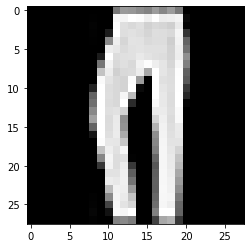

Label : 1


In [31]:
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label : {label}")